# 行为评分卡 Behaviour Scorecard
### 数据来源： Github， 已经过预处理
### 内容：
1. 构造特征（逾期记录、额度使用、还款）
2. 卡方分箱， 计算WOE
3. 单变量分析(IV)和多变量分析(VIF)
4. 建模
5. 评价模型
6. 评分

In [1]:
import pandas as pd
import numpy as np
import pickle
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn import ensemble
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
trainData = pd.read_csv('../Behaviour Scorecard/trainset_org.csv',header = 0,engine ='python')
testData = pd.read_csv('../Behaviour Scorecard/testData.csv',header = 0,engine ='python')

In [3]:
trainData.head()

,CUST_ID,Loan_Amount,OS_0,OS_1,OS_2,OS_3,OS_4,OS_5,OS_6,OS_7,...,Delq3_4,Delq3_5,Delq3_6,Delq3_7,Delq3_8,Delq3_9,Delq3_10,Delq3_11,Delq3_12,label
0,5f97c74f9eee425083c9535536c96f75,90000,25947.77,86565.62,112978.46,41926.58,81568.91,40556.02,40700.32,53312.53,...,0,0,0,0,0,0,0,0,0,0
1,892a7cdc80e348a8b4f38ac88cf78698,180000,99887.21,99887.21,17689.21,54578.30,108546.73,177679.61,122616.69,26987.69,...,0,0,0,0,0,0,0,0,0,0
2,aa3f22edc65c441c8848bf9b552ef7af,150000,74086.91,148254.81,8696.58,67064.81,61453.20,36049.51,64204.80,14712.80,...,0,0,0,0,0,0,0,0,0,0
3,13be7b52263845bd8ebc699533330e6f,60000,19569.47,43546.68,82987.16,91802.29,31247.55,28472.87,26393.94,15894.49,...,0,0,0,0,0,0,0,0,0,0
4,8820e38b407446c696e5e28315cf3014,100000,50058.11,97288.48,137752.33,184847.10,8141.10,24649.20,65290.07,31820.01,...,0,0,0,0,0,0,0,0,0,0


+ Loan_Amount:总额度
+ OS：未还金额
+ Payment：还款金额
+ Spend：使用金额
+ Delq：逾期情况（分成3类违约情况(1最轻，3最重)，每类情况下1代表违约）

# 1. 构造特征

In [4]:
allFeatures = []

## 1.1 逾期类型
逾期类型的特征在行为评分卡（预测违约行为）中，一般是非常显著的变量。  
通过设定时间窗口，可以衍生以下类型的逾期变量：

In [5]:
#衍生逾期类型的特征的函数
def DelqFeatures(event,window,type):
    '''
    :parms event 数据框
    :parms windows 时间窗口
    :parms type 响应事件类型
    '''
    current = 12
    start = 12 - window + 1
    #delq1、delq2、delq3为了获取window相对应的dataframe范围
    delq1 = [event[a] for a in ['Delq1_' + str(t) for t in range(current, start - 1, -1)]]
    delq2 = [event[a] for a in ['Delq2_' + str(t) for t in range(current, start - 1, -1)]]
    delq3 = [event[a] for a in ['Delq3_' + str(t) for t in range(current, start - 1, -1)]]
    if type == 'max delq':
        if max(delq3) == 1:
            return 3
        elif max(delq2) == 1:
            return 2
        elif max(delq1) == 1:
            return 1
        else:
            return 0
    if type in ['M0 times','M1 times', 'M2 times']:
        if type.find('M0')>-1:
            return sum(delq1)
        elif type.find('M1')>-1:
            return sum(delq2)
        else:
            return sum(delq3)

In [6]:
# 考虑过去1个月，3个月，6个月，12个月
for t in [1,3,6,12]:
    # 过去t时间窗口内的最大逾期状态
    allFeatures.append('maxDelqL'+str(t)+"M")
    trainData['maxDelqL'+str(t)+"M"] = trainData.apply(lambda x: DelqFeatures(x,t,'max delq'),axis=1)
 
    # 过去t时间窗口内的，M0,M1,M2的次数
    allFeatures.append('M0FreqL' + str(t) + "M")
    trainData['M0FreqL' + str(t) + "M"] = trainData.apply(lambda x: DelqFeatures(x,t,'M0 times'),axis=1)
 
    allFeatures.append('M1FreqL' + str(t) + "M")
    trainData['M1FreqL' + str(t) + "M"] = trainData.apply(lambda x: DelqFeatures(x, t, 'M1 times'), axis=1)
 
    allFeatures.append('M2FreqL' + str(t) + "M")
    trainData['M2FreqL' + str(t) + "M"] = trainData.apply(lambda x: DelqFeatures(x, t, 'M2 times'), axis=1)
 

## 1.2 额度使用率
额度使用率类型特征在行为评分卡模型中，通常是与违约高度相关的

In [7]:
#衍生额度使用率类型特征的函数
def UrateFeatures(event, window, type):
    '''
    :parms event 数据框
    :parms windows 时间窗口
    :parms type 响应事件类型
    '''
    current = 12
    start = 12 - window + 1
    #获取在数据框内有效区域
    monthlySpend = [event[a] for a in ['Spend_' + str(t) for t in range(current, start - 1, -1)]]
    #获取授信总额度
    limit = event['Loan_Amount']
    #月使用率
    monthlyUrate = [x / limit for x in monthlySpend]
    if type == 'mean utilization rate':
        return np.mean(monthlyUrate)
    if type == 'max utilization rate':
        return max(monthlyUrate)
    #月额度使用率增加的月份
    if type == 'increase utilization rate':
        #val[0:-1]表示第一个元素到倒数第二个元素的切片
        currentUrate = monthlyUrate[0:-1]
        #val[1:]表示第二个元素到最后一个元素的切片
        previousUrate = monthlyUrate[1:]
        compareUrate = [int(x[0]>x[1]) for x in zip(currentUrate,previousUrate)]
        return sum(compareUrate)

In [8]:
# 考虑过去1个月，3个月，6个月，12个月
for t in [1,3,6,12]:
    # 过去t时间窗口内的最大月额度使用率
    allFeatures.append('maxUrateL' + str(t) + "M")
    trainData['maxUrateL' + str(t) + "M"] = trainData.apply(lambda x: UrateFeatures(x,t,'max utilization rate'),axis = 1)
 
    # 过去t时间窗口内的平均月额度使用率
    allFeatures.append('avgUrateL' + str(t) + "M")
    trainData['avgUrateL' + str(t) + "M"] = trainData.apply(lambda x: UrateFeatures(x, t, 'mean utilization rate'),axis=1)
 
    # 过去t时间窗口内，月额度使用率增加的月份数量。该变量要求t>1
    if t > 1:
        allFeatures.append('increaseUrateL' + str(t) + "M")
        trainData['increaseUrateL' + str(t) + "M"] = trainData.apply(lambda x: UrateFeatures(x, t, 'increase utilization rate'),axis=1)

## 1.3 还款
还款类型特征也是行为评分卡模型中常用的特征

In [9]:
#衍生还款类型特征的函数
def PaymentFeatures(event, window, type):
    current = 12
    start = 12 - window + 1
    #月还款金额
    currentPayment = [event[a] for a in ['Payment_' + str(t) for t in range(current, start - 1, -1)]]
    #上月使用金额，错位一下
    previousOS = [event[a] for a in ['OS_' + str(t) for t in range(current-1, start - 2, -1)]]
    monthlyPayRatio = []
    for Pay_OS in zip(currentPayment,previousOS):
        #前一个月使用了才会产生还款
        if Pay_OS[1]>0:
            payRatio = Pay_OS[0]*1.0 / Pay_OS[1]
            monthlyPayRatio.append(payRatio)
        #前一个月没使用，就按照100%还款
        else:
            monthlyPayRatio.append(1)
    if type == 'min payment ratio':
        return min(monthlyPayRatio)
    if type == 'max payment ratio':
        return max(monthlyPayRatio)
    if type == 'mean payment ratio':
        total_payment = sum(currentPayment)
        total_OS = sum(previousOS)
        if total_OS > 0:
            return total_payment / total_OS
        else:
            return 1

In [10]:
# 考虑过去1个月，3个月，6个月，12个月
for t in [1,3,6,12]:
    # 过去t时间窗口内的最大月还款率
    allFeatures.append('maxPayL' + str(t) + "M")
    trainData['maxPayL' + str(t) + "M"] = trainData.apply(lambda x: PaymentFeatures(x, t, 'max payment ratio'),axis=1)
    # 过去t时间窗口内的最小月还款率
    allFeatures.append('minPayL' + str(t) + "M")
    trainData['minPayL' + str(t) + "M"] = trainData.apply(lambda x: PaymentFeatures(x, t, 'min payment ratio'),axis=1)
    # 过去t时间窗口内的平均月还款率
    allFeatures.append('avgPayL' + str(t) + "M")
    trainData['avgPayL' + str(t) + "M"] = trainData.apply(lambda x: PaymentFeatures(x, t, 'mean payment ratio'),axis=1)

# 2. 分箱，计算WOE并编码

In [11]:
categoricalFeatures = []
numericalFeatures = []
WOE_IV_dict = {}
for var in allFeatures:
    if len(set(trainData[var])) > 5:
        numericalFeatures.append(var)
    else:
        categoricalFeatures.append(var)

## 2.1 检查bad rate在分类特征中的单调性

In [12]:
#计算变量分箱之后各分箱的坏样本率
def BinBadRate(df, col, target, grantRateIndicator=0):
    '''
    :param df: 需要计算好坏比率的数据集
    :param col: 需要计算好坏比率的特征
    :param target: 好坏标签
    :param grantRateIndicator: 1返回总体的坏样本率，0不返回
    :return: 每箱的坏样本率，以及总体的坏样本率（当grantRateIndicator＝＝1时）
    '''
    #print(df.groupby([col])[target])
    total = df.groupby([col])[target].count()
    #print(total)
    total = pd.DataFrame({'total': total})
    #print(total)
    bad = df.groupby([col])[target].sum()
    bad = pd.DataFrame({'bad': bad})
    #合并
    regroup = total.merge(bad, left_index=True, right_index=True, how='left')
    #print(regroup)
    regroup.reset_index(level=0, inplace=True)
    #print(regroup)
    #计算坏样本率
    regroup['bad_rate'] = regroup.apply(lambda x: x.bad * 1.0 / x.total, axis=1)
    #print(regroup)
    #生成字典，（变量名取值：坏样本率）
    dicts = dict(zip(regroup[col],regroup['bad_rate']))
    if grantRateIndicator==0:
        return (dicts, regroup)
    N = sum(regroup['total'])
    B = sum(regroup['bad'])
    #总体样本率
    overallRate = B * 1.0 / N
    return (dicts, regroup, overallRate)

In [13]:
## 判断某变量的坏样本率是否单调
def BadRateMonotone(df, sortByVar, target,special_attribute = []):
    '''
    :param df: 包含检验坏样本率的变量，和目标变量
    :param sortByVar: 需要检验坏样本率的变量
    :param target: 目标变量，0、1表示好、坏
    :param special_attribute: 不参与检验的特殊值
    :return: 坏样本率单调与否(True代表单调， False代表不单调)
    '''
    df2 = df.loc[~df[sortByVar].isin(special_attribute)]
    if len(set(df2[sortByVar])) <= 2:
        return True
    regroup = BinBadRate(df2, sortByVar, target)[1]
    combined = zip(regroup['total'],regroup['bad'])
    badRate = [x[1]*1.0/x[0] for x in combined]
    badRateNotMonotone = [badRate[i]<badRate[i+1] and badRate[i] < badRate[i-1] or badRate[i]>badRate[i+1] and badRate[i] > badRate[i-1]
                          for i in range(1,len(badRate)-1)]
    if True in badRateNotMonotone:
        return False
    else:
        return True

In [14]:
not_monotone =[]
for var in categoricalFeatures:
    if not BadRateMonotone(trainData, var, 'label'):
        not_monotone.append(var)

In [15]:
print("数值取值小于5类别型变量{}坏样本率不单调".format(not_monotone))

数值取值小于5类别型变量['M1FreqL3M', 'M2FreqL3M', 'maxDelqL12M']坏样本率不单调


`M1FreqL3M`，`M2FreqL3M`, `maxDelqL12M'` 是不单调的，需要合并其中某些类别

### M2FreqL3M

In [16]:
trainData.groupby(['M2FreqL3M'])['label'].mean()  #检查单调性

M2FreqL3M
0    0.120702
1    0.958974
2    0.963636
3    0.666667
Name: label, dtype: float64

In [17]:
trainData.groupby(['M2FreqL3M'])['label'].count() 

M2FreqL3M
0    27456
1      585
2       55
3        3
Name: label, dtype: int64

其中，M2FreqL3M＝3总共只有3个样本，因此要进行合并  
将`M2FreqL3M` >=1的合并为一组，并计算WOE值

In [18]:
#计算WOE值
def CalcWOE(df, col, target):
    '''
    :param df: 包含需要计算WOE的变量和目标变量
    :param col: 需要计算WOE、IV的变量，必须是分箱后的变量，或者不需要分箱的类别型变量
    :param target: 目标变量，0、1表示好、坏
    :return: 返回WOE和IV
    '''
    total = df.groupby([col])[target].count()
    total = pd.DataFrame({'total': total})
    bad = df.groupby([col])[target].sum()
    bad = pd.DataFrame({'bad': bad})
    regroup = total.merge(bad, left_index=True, right_index=True, how='left')
    regroup.reset_index(level=0, inplace=True)
    N = sum(regroup['total'])
    B = sum(regroup['bad'])
    regroup['good'] = regroup['total'] - regroup['bad']
    G = N - B
    regroup['bad_pcnt'] = regroup['bad'].map(lambda x: x*1.0/B)
    regroup['good_pcnt'] = regroup['good'].map(lambda x: x * 1.0 / G)
    regroup['WOE'] = regroup.apply(lambda x: np.log(x.good_pcnt*1.0/x.bad_pcnt),axis = 1)
    WOE_dict = regroup[[col,'WOE']].set_index(col).to_dict(orient='index')
    for k, v in WOE_dict.items():
        WOE_dict[k] = v['WOE']
    IV = regroup.apply(lambda x: (x.good_pcnt-x.bad_pcnt)*np.log(x.good_pcnt*1.0/x.bad_pcnt),axis = 1)
    IV = sum(IV)
    return {"WOE": WOE_dict, 'IV':IV}

In [19]:
# 将M2FreqL3M>=1的合并为一组
trainData['M2FreqL3M_Bin'] = trainData['M2FreqL3M'].apply(lambda x: int(x>=1))
trainData.groupby(['M2FreqL3M_Bin'])['label'].mean()

M2FreqL3M_Bin
0    0.120702
1    0.958009
Name: label, dtype: float64

In [20]:
#计算将M2FreqL3M的WOE值
WOE_IV_dict['M2FreqL3M_Bin'] = CalcWOE(trainData, 'M2FreqL3M_Bin', 'label')

In [21]:
WOE_IV_dict

{'M2FreqL3M_Bin': {'WOE': {0: 0.16936574889989445, 1: -4.943841491903861},
  'IV': 0.7957473203620947}}

### M1FreqL3M

In [22]:
trainData.groupby(['M1FreqL3M'])['label'].mean()  #检查单调性

M1FreqL3M
0    0.049511
1    0.409583
2    0.930825
3    0.927083
Name: label, dtype: float64

In [23]:
trainData.groupby(['M1FreqL3M'])['label'].count()

M1FreqL3M
0    22379
1     4800
2      824
3       96
Name: label, dtype: int64

除了`M1FreqL3M`＝3外， 其他组别的bad rate单调。
此外，`M1FreqL3M`＝0占比很大，因此将`M1FreqL3M`>=1的分为一组

In [24]:
trainData['M1FreqL3M_Bin'] = trainData['M1FreqL3M'].apply(lambda x: int(x>=1))
trainData.groupby(['M1FreqL3M_Bin'])['label'].mean()

M1FreqL3M_Bin
0    0.049511
1    0.493357
Name: label, dtype: float64

In [25]:
WOE_IV_dict['M1FreqL3M_Bin'] = CalcWOE(trainData, 'M1FreqL3M_Bin', 'label')

对其他单调的类别型变量，检查是否有一箱的占比低于5%。 如果有，将该变量进行合并

In [26]:
small_bin_var = []
large_bin_var = []
N = trainData.shape[0]
for var in categoricalFeatures:
    if var not in not_monotone:
        total = trainData.groupby([var])[var].count()
        pcnt = total * 1.0 / N
        if min(pcnt)<0.05:
            small_bin_var.append({var:pcnt.to_dict()})
        else:
            large_bin_var.append(var)

In [27]:
small_bin_var

[{'maxDelqL1M': {0: 0.6037937293142105,
   1: 0.31880138083205806,
   2: 0.0691839567244386,
   3: 0.008220933129292857}},
 {'M2FreqL1M': {0: 0.9917790668707072, 1: 0.008220933129292857}},
 {'maxDelqL3M': {0: 0.22637816292394747,
   1: 0.5700558738745151,
   2: 0.18068258656891703,
   3: 0.022883376632620377}},
 {'maxDelqL6M': {0: 0.05722623580910353,
   1: 0.5848962596533684,
   2: 0.3128581088294957,
   3: 0.04501939570803232}},
 {'M2FreqL6M': {0: 0.9549806042919677,
   1: 0.04003701199330937,
   2: 0.004590910708566141,
   3: 0.00032029609594647497,
   4: 7.117691021032777e-05}},
 {'M2FreqL12M': {0: 0.9233424677034769,
   1: 0.0665148225915513,
   2: 0.009217409872237447,
   3: 0.0008185344674187694,
   4: 0.00010676536531549166}}]

对于`M2FreqL1M`、`M2FreqL6M`和`M2FreqL12M`，由于有部分箱占了很大比例,没有区分度，故删除

In [28]:
allFeatures.remove('M2FreqL1M')
allFeatures.remove('M2FreqL6M')
allFeatures.remove('M2FreqL12M')

In [29]:
# 根据条件合并分箱
def MergeByCondition(x,condition_list):
    #condition_list是条件列表。满足第几个condition，就输出几
    s = 0
    for condition in condition_list:
        if eval(str(x)+condition):
            return s
        else:
            s+=1
    return s

In [30]:
#对于small_bin_var中的其他变量，将最小的箱和相邻的箱进行合并并计算WOE
trainData['maxDelqL1M_Bin'] = trainData['maxDelqL1M'].apply(lambda x: MergeByCondition(x,['==0','==1','>=2']))
trainData['maxDelqL3M_Bin'] = trainData['maxDelqL3M'].apply(lambda x: MergeByCondition(x,['==0','==1','>=2']))
trainData['maxDelqL6M_Bin'] = trainData['maxDelqL6M'].apply(lambda x: MergeByCondition(x,['==0','==1','>=2']))

In [31]:
for var in ['maxDelqL1M_Bin','maxDelqL3M_Bin','maxDelqL6M_Bin']:
    WOE_IV_dict[var] = CalcWOE(trainData, var, 'label')

对于不需要合并、原始箱的bad rate单调的特征，直接计算WOE和IV

In [32]:
for var in large_bin_var:
    WOE_IV_dict[var] = CalcWOE(trainData, var, 'label')

## 2.2 卡方分箱

#### 步骤：
1. 初始化阶段：首先按照属性值的大小进行排序（对于非连续特征，需要先做数值转换，比如转为坏人率，然后排序），然后每个属性值单独作为一组。
2. 合并阶段：
    1. 对每一对相邻的组，计算卡方值。
    2. 根据计算的卡方值，对其中最小的一对邻组合并为一组。
    3. 不断重复A,B直到计算出的卡方值都不低于事先设定的阈值，或者分组数达到一定的条件（如最小分组数5，最大分组数8）。
    
#### 卡方值计算：
![](http://ddrvcn.oss-cn-hangzhou.aliyuncs.com/2019/10/RF3Ire.png)
+ $i = 1,2$：表示相邻的两个分箱数目
+ $j = 1,2$: 表示目标变量的类别数，比如目标是网贷违约的好和坏，就是两类。

In [33]:
# 根据节点进行分箱，结果为：Bin+编号形式
def AssignBin(x, cutOffPoints,special_attribute=[]):
    '''
    :param x: 某个变量的某个取值
    :param cutOffPoints: 上述变量的分箱结果，用切分点表示
    :param special_attribute:  不参与分箱的特殊取值
    :return: 分箱后的对应的第几个箱，从0开始
    for example, if cutOffPoints = [10,20,30], if x = 7, return Bin 0. If x = 35, return Bin 3
    '''
    numBin = len(cutOffPoints) + 1 + len(special_attribute)
    if x in special_attribute:
        i = special_attribute.index(x)+1
        return 'Bin {}'.format(0-i)
    if x<=cutOffPoints[0]:
        return 'Bin 0'
    elif x > cutOffPoints[-1]:
        return 'Bin {}'.format(numBin-1)
    else:
        for i in range(0,numBin-1):
            if cutOffPoints[i] < x <=  cutOffPoints[i+1]:
                return 'Bin {}'.format(i+1)

In [34]:
# 根据每个分箱点对应的数值，把变量的具体取值映射成分箱结果（该分箱对应切分点的数值）
def AssignGroup(x, bin):
    '''
    :param x: 某个变量的某个取值
    :param bin: 每个分箱点对应的数值
    :return: x在分箱结果下的映射（该分箱对应切分点的数值）
    '''
    N = len(bin)
    if x<=min(bin):
        return min(bin)
    elif x>max(bin):
        return 10e10
    else:
        for i in range(N-1):
            if bin[i] < x <= bin[i+1]:
                return bin[i+1]

In [35]:
def SplitData(df, col, numOfSplit, special_attribute=[]):
    '''
    :param df: 按照col排序后的数据集
    :param col: 待分箱的变量
    :param numOfSplit: 切分的组别数
    :param special_attribute: 在切分数据集的时候，某些特殊值需要排除在外
    :return: 每个分箱点对应的数值 (把原始细粒度的col重新划分成粗粒度的值，便于分箱中的合并处理)
    '''
    df2 = df.copy()
    if special_attribute != []:
        df2 = df.loc[~df[col].isin(special_attribute)]
    N = df2.shape[0]#行数
    #" / "就表示 浮点数除法，返回浮点结果;" // "表示整数除法
    n = N//numOfSplit #每组样本数
    splitPointIndex = [i*n for i in range(1,numOfSplit)] #分割点的下标
    '''
    [i*2 for i in range(1,100)]
    [2, 4, 6, 8, 10,......,198]
    '''
    rawValues = sorted(list(df2[col])) #对取值进行排序
    #取到粗糙卡方划分节点
    splitPoint = [rawValues[i] for i in splitPointIndex] #分割点对应的数据取值
    splitPoint = sorted(list(set(splitPoint)))
    return splitPoint

In [36]:
#计算卡方值的函数
def Chi2(df, total_col, bad_col, overallRate):
    '''
    :param df: 包含全部样本总计与坏样本总计的数据框
    :param total_col: 每个分箱中全部样本的个数
    :param bad_col: 每个分箱中坏样本的个数
    :param overallRate: 全体样本的坏样本占比
    :return: 卡方值
    '''
    df2 = df.copy()
    # 期望坏样本个数＝全部样本个数*平均坏样本占比
    df2['expected'] = df[total_col].apply(lambda x: x*overallRate)
    combined = zip(df2['expected'], df2[bad_col])
    chi = [(i[0]-i[1])**2/i[0] for i in combined]
    chi2 = sum(chi)
    return chi2

In [37]:
##ChiMerge_MaxInterval：通过指定最大间隔数，使用卡方值分割连续变量
def ChiMerge(df, col, target, max_interval=5,special_attribute=[],minBinPcnt=0):
    '''
    :param df: 包含目标变量与分箱属性的数据框
    :param col: 需要分箱的特征
    :param target: 目标变量，取值0或1
    :param max_interval: 最大分箱数。如果原始属性的取值个数低于该参数，不执行这段函数
    :param special_attribute: 不参与分箱的属性取值，缺失值的情况
    :param minBinPcnt：最小箱的占比，默认为0
    :return: 分箱结果
    '''
    colLevels = sorted(list(set(df[col])))
    N_distinct = len(colLevels)#不同的取值个数
    if N_distinct <= max_interval:  #如果原始属性的取值个数低于max_interval，不执行这段函数
        print ("原始属性{}的取值个数低于max_interval".format(col))
        #分箱分数间隔段，少一个值也可以
        #返回值colLevels会少一个最大值
        return colLevels[:-1]
    else:
        if len(special_attribute)>=1:
            #df1数据框取trainData中col那一列为特殊值的数据集
            #df1 = df.loc[df[col].isin(special_attribute)]
            print('{} 有缺失值的情况'.format(col))
            #用逆函数对筛选后的结果取余，起删除指定行作用
            df2 = df.loc[~df[col].isin(special_attribute)]
        else:
            df2 = df.copy()
        N_distinct = len(list(set(df2[col])))#该特征不同的取值
 
        # 步骤一: 通过col对数据集进行分组，求出每组的总样本数与坏样本数
        if N_distinct > 100:
            '''
            split_x样例
            [2, 8, 9.3, 10, 30,......, 1800]
            '''
            split_x = SplitData(df2, col, 100)
            #把值变为划分点的值
            df2['temp'] = df2[col].map(lambda x: AssignGroup(x, split_x))
        else:
            #假如数值取值小于100就不发生变化了
            df2['temp'] = df2[col]
        # 总体bad rate将被用来计算expected bad count
        (binBadRate, regroup, overallRate) = BinBadRate(df2, 'temp', target, grantRateIndicator=1)
 
        # 对每组属性进行排序和记录
        colLevels = sorted(list(set(df2['temp'])))
        groupIntervals = [[i] for i in colLevels]
 
        # 步骤二：建立循环，不断合并最优的相邻两个组别，直到：
        # 1，最终分裂出来的分箱数<＝预设的最大分箱数
        # 2，每箱的占比不低于预设值（可选）
        # 3，每箱同时包含好坏样本
        # 如果有特殊属性，那么最终分裂出来的分箱数＝预设的最大分箱数－特殊属性的个数
        split_intervals = max_interval - len(special_attribute)
        while (len(groupIntervals) > split_intervals):  # 终止条件: 当前分箱数＝预设的分箱数
            # 每次循环时, 计算合并相邻组别后的卡方值。具有最小卡方值的合并方案，是最优方案
            #存储卡方值
            chisqList = []
            for k in range(len(groupIntervals)-1):
                temp_group = groupIntervals[k] + groupIntervals[k+1]
                df2b = regroup.loc[regroup['temp'].isin(temp_group)]
                chisq = Chi2(df2b, 'total', 'bad', overallRate)
                chisqList.append(chisq)
            best_comnbined = chisqList.index(min(chisqList))
            groupIntervals[best_comnbined] = groupIntervals[best_comnbined] + groupIntervals[best_comnbined+1]
            # 去除区间
            groupIntervals.remove(groupIntervals[best_comnbined+1])
        groupIntervals = [sorted(i) for i in groupIntervals]
        cutOffPoints = [max(i) for i in groupIntervals[:-1]]
 
        # 应用卡方分箱，进行下一步检验
        groupedvalues = df2['temp'].apply(lambda x: AssignBin(x, cutOffPoints))
        # 检查是否有箱没有好或者坏样本。如果有，需要跟相邻的箱进行合并，直到每箱同时包含好坏样本
        df2['temp_Bin'] = groupedvalues
        (binBadRate,regroup) = BinBadRate(df2, 'temp_Bin', target)
        [minBadRate, maxBadRate] = [min(binBadRate.values()),max(binBadRate.values())]
        while minBadRate ==0 or maxBadRate == 1:
            # 找出全部为好／坏样本的箱
            indexForBad01 = regroup[regroup['bad_rate'].isin([0,1])].temp_Bin.tolist()
            bin=indexForBad01[0]
            # 如果是最后一箱，则需要和上一个箱进行合并，也就意味着分裂点cutOffPoints中的最后一个需要移除
            if bin == max(regroup.temp_Bin):
                cutOffPoints = cutOffPoints[:-1]
            # 如果是第一箱，则需要和下一个箱进行合并，也就意味着分裂点cutOffPoints中的第一个需要移除
            elif bin == min(regroup.temp_Bin):
                cutOffPoints = cutOffPoints[1:]
            # 如果是中间的某一箱，则需要和前后中的一个箱进行合并，依据是较小的卡方值
            else:
                # 和前一箱进行合并，并且计算卡方值
                currentIndex = list(regroup.temp_Bin).index(bin)
                prevIndex = list(regroup.temp_Bin)[currentIndex - 1]
                df3 = df2.loc[df2['temp_Bin'].isin([prevIndex, bin])]
                (binBadRate, df2b) = BinBadRate(df3, 'temp_Bin', target)
                chisq1 = Chi2(df2b, 'total', 'bad', overallRate)
                # 和后一箱进行合并，并且计算卡方值
                laterIndex = list(regroup.temp_Bin)[currentIndex + 1]
                df3b = df2.loc[df2['temp_Bin'].isin([laterIndex, bin])]
                (binBadRate, df2b) = BinBadRate(df3b, 'temp_Bin', target)
                chisq2 = Chi2(df2b, 'total', 'bad', overallRate)
                if chisq1 < chisq2:
                    cutOffPoints.remove(cutOffPoints[currentIndex - 1])
                else:
                    cutOffPoints.remove(cutOffPoints[currentIndex])
            # 完成合并之后，需要再次计算新的分箱准则下，每箱是否同时包含好坏样本
            groupedvalues = df2['temp'].apply(lambda x: AssignBin(x, cutOffPoints))
            df2['temp_Bin'] = groupedvalues
            (binBadRate, regroup) = BinBadRate(df2, 'temp_Bin', target)
            [minBadRate, maxBadRate] = [min(binBadRate.values()), max(binBadRate.values())]
 
        # 需要检查分箱后的最小占比
        if minBinPcnt > 0:
            groupedvalues = df2['temp'].apply(lambda x: AssignBin(x, cutOffPoints))
            df2['temp_Bin'] = groupedvalues
            #value_counts每个数值出现了多少次
            valueCounts = groupedvalues.value_counts().to_frame()
            N=sum(valueCounts['temp'])
            valueCounts['pcnt'] = valueCounts['temp'].apply(lambda x: x * 1.0 / N)
            valueCounts = valueCounts.sort_index()
            minPcnt = min(valueCounts['pcnt'])
            #一定要箱数大于2才可以，要不就不能再合并了
            while minPcnt < minBinPcnt and len(cutOffPoints) > 2:
                # 找出占比最小的箱
                indexForMinPcnt = valueCounts[valueCounts['pcnt'] == minPcnt].index.tolist()[0]
                # 如果占比最小的箱是最后一箱，则需要和上一个箱进行合并，也就意味着分裂点cutOffPoints中的最后一个需要移除
                if indexForMinPcnt == max(valueCounts.index):
                    cutOffPoints = cutOffPoints[:-1]
                # 如果占比最小的箱是第一箱，则需要和下一个箱进行合并，也就意味着分裂点cutOffPoints中的第一个需要移除
                elif indexForMinPcnt == min(valueCounts.index):
                    cutOffPoints = cutOffPoints[1:]
                # 如果占比最小的箱是中间的某一箱，则需要和前后中的一个箱进行合并，依据是较小的卡方值
                else:
                    # 和前一箱进行合并，并且计算卡方值
                    currentIndex = list(valueCounts.index).index(indexForMinPcnt)
                    prevIndex = list(valueCounts.index)[currentIndex - 1]
                    df3 = df2.loc[df2['temp_Bin'].isin([prevIndex, indexForMinPcnt])]
                    (binBadRate, df2b) = BinBadRate(df3, 'temp_Bin', target)
                    chisq1 = Chi2(df2b, 'total', 'bad', overallRate)
                    # 和后一箱进行合并，并且计算卡方值
                    laterIndex = list(valueCounts.index)[currentIndex + 1]
                    df3b = df2.loc[df2['temp_Bin'].isin([laterIndex, indexForMinPcnt])]
                    (binBadRate, df2b) = BinBadRate(df3b, 'temp_Bin', target)
                    chisq2 = Chi2(df2b, 'total', 'bad', overallRate)
                    if chisq1 < chisq2:
                        cutOffPoints.remove(cutOffPoints[currentIndex - 1])
                    else:
                        cutOffPoints.remove(cutOffPoints[currentIndex])
        cutOffPoints = special_attribute + cutOffPoints
        return cutOffPoints

#### 分箱条件：
1. 箱数不超过5
2. bad rate单调
3. 每箱占比不低于5%

In [38]:
bin_dict = []
for var in numericalFeatures:
    binNum = 5
    newBin = var + '_Bin'
    bin = ChiMerge(trainData, var, 'label',max_interval=binNum,minBinPcnt = 0.05)
    trainData[newBin] = trainData[var].apply(lambda x: AssignBin(x,bin))
    # 如果不满足单调性，就降低分箱个数
    while not BadRateMonotone(trainData, newBin, 'label'):
        binNum -= 1
        bin = ChiMerge(trainData, var, 'label', max_interval=binNum, minBinPcnt=0.05)
        trainData[newBin] = trainData[var].apply(lambda x: AssignBin(x, bin))
    WOE_IV_dict[newBin] = CalcWOE(trainData, newBin, 'label')
    bin_dict.append({var:bin})

# 3. 单变量分析和多变量分析

## 3.1 选取IV高于0.02的变量

<BarContainer object of 33 artists>

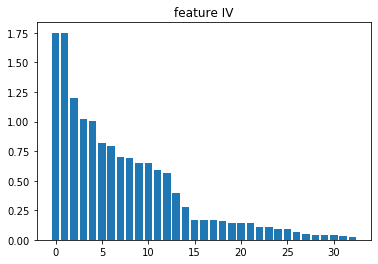

In [39]:
#  选取IV高于0.02的变量
high_IV = [(k,v['IV']) for k,v in WOE_IV_dict.items() if v['IV'] >= 0.02]
high_IV_sorted = sorted(high_IV, key=lambda k: k[1],reverse=True)
IV_values = [i[1] for i in high_IV_sorted]
IV_name = [i[0] for i in high_IV_sorted]
plt.title('feature IV')
plt.bar(range(len(IV_values)),IV_values)

In [40]:
# 计算WOE
for (var,iv) in high_IV:
    newVar = var+"_WOE"
    trainData[newVar] = trainData[var].map(lambda x: WOE_IV_dict[var]['WOE'][x])

## 3.2 多变量分析：比较两两线性相关性
如果相关系数的绝对值高于阈值，剔除IV较低的一个


In [41]:
deleted_index = []
cnt_vars = len(high_IV_sorted)
for i in range(cnt_vars):
    if i in deleted_index:
        continue
    x1 = high_IV_sorted[i][0]+"_WOE"
    for j in range(cnt_vars):
        if i == j or j in deleted_index:
            continue
        y1 = high_IV_sorted[j][0]+"_WOE"
        roh = np.corrcoef(trainData[x1],trainData[y1])[0,1]
        if abs(roh)>0.7:
            x1_IV = high_IV_sorted[i][1]
            y1_IV = high_IV_sorted[j][1]
            if x1_IV > y1_IV:
                deleted_index.append(j)
            else:
                deleted_index.append(i)

In [42]:
# 提取剩余特征
single_analysis_vars = [high_IV_sorted[i][0]+"_WOE" for i in range(cnt_vars) if i not in deleted_index]
single_analysis_vars

['maxDelqL3M_Bin_WOE',
 'M1FreqL6M_Bin_WOE',
 'M0FreqL3M_WOE',
 'M2FreqL3M_Bin_WOE',
 'M1FreqL12M_Bin_WOE',
 'maxDelqL1M_Bin_WOE',
 'M0FreqL6M_Bin_WOE',
 'avgPayL6M_Bin_WOE',
 'avgPayL12M_Bin_WOE',
 'M0FreqL12M_Bin_WOE',
 'avgPayL1M_Bin_WOE',
 'increaseUrateL6M_Bin_WOE',
 'maxPayL6M_Bin_WOE',
 'minPayL3M_Bin_WOE',
 'avgUrateL1M_Bin_WOE',
 'increaseUrateL3M_WOE',
 'avgUrateL3M_Bin_WOE',
 'maxUrateL3M_Bin_WOE',
 'minPayL6M_Bin_WOE',
 'avgUrateL6M_Bin_WOE',
 'maxPayL12M_Bin_WOE',
 'maxUrateL6M_Bin_WOE',
 'increaseUrateL12M_Bin_WOE']

## 3.3 协方差热力图

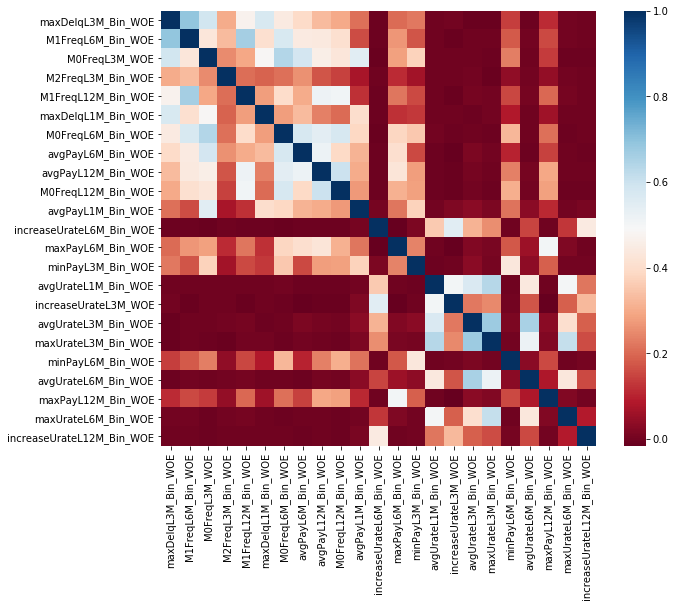

In [43]:
X = trainData[single_analysis_vars]
f, ax = plt.subplots(figsize=(10, 8))
corr = X.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap='RdBu',square=True, ax=ax)

## 3.4 多变量分析：VIF

+ 方差扩大因子VIF可以度量多重共线性的严重程度  
+ 每个自变量和其他自变量之间的辅助线性回归方程来检验模型当中是否存在多重共线性，
$$x_{i}=c_{0}+c_{1}x_{1}+c_{2}x_{2}+...+c_{i-1}x_{i-1}+c_{i+1}x_{i+1}+...+c_{n}x_{n}$$
+ 回归方程的$R^2$代表$x_{i}$能用其他变量解释的程度，也就代表了自变量本身多重共线性的强度，定义自变量$x_{i}$的方差扩大因子$VIF_{i}$为
$$VIF_{i}=\frac{1}{1-R^2}$$
+ 当VIF>10，说明自变量$x_{i}$与其他变量具有严重的多重共线性

In [44]:
X = np.matrix(trainData[single_analysis_vars])
VIF_list = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print(max(VIF_list))

3.8095783502856286


最大的VIF是 3.429，小于10，因此认为没有多重共线性


In [45]:
multi_analysis = single_analysis_vars

# 4. 建立逻辑回归模型预测违约

## 4.1 逻辑回归

In [46]:
X = trainData[multi_analysis]
X = sm.add_constant(X)
y = trainData['label']

C:\Users\Junbo\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [47]:
logit = sm.Logit(y, X)
logit_result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.258296
         Iterations 7


In [48]:
print(logit_result.summary())

                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                28099
Model:                          Logit   Df Residuals:                    28075
Method:                           MLE   Df Model:                           23
Date:                Mon, 30 Mar 2020   Pseudo R-squ.:                  0.3618
Time:                        16:55:23   Log-Likelihood:                -7257.9
converged:                       True   LL-Null:                       -11372.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -1.8127      0.024    -76.329      0.000      -1.859      -1.766
maxDelqL3M_Bin_WOE           -0.7358      0.027    -27.222      0.000      -0.789     

其中变量 `maxPayL12M_Bin_WOE`, `M0FreqL12M_Bin_WOE`, `minPayL6M_Bin_WOE`, `increaseUrateL12M_Bin_WOE`, `M0FreqL6M_Bin_WOE`, `minPayL3M_Bin_WOE`, `avgPayL1M_Bin_WOE`的系数为正，需要单独检验

In [49]:
sm.Logit(y, trainData['maxPayL12M_Bin_WOE']).fit().params

Optimization terminated successfully.
         Current function value: 0.688430
         Iterations 4


maxPayL12M_Bin_WOE   -0.980206
dtype: float64

In [50]:
sm.Logit(y, trainData['M0FreqL12M_Bin_WOE']).fit().params

Optimization terminated successfully.
         Current function value: 0.658669
         Iterations 5


M0FreqL12M_Bin_WOE   -1.050918
dtype: float64

In [51]:
sm.Logit(y, trainData['minPayL6M_Bin_WOE']).fit().params

Optimization terminated successfully.
         Current function value: 0.687305
         Iterations 5


minPayL6M_Bin_WOE   -0.812302
dtype: float64

In [52]:
sm.Logit(y, trainData['increaseUrateL12M_Bin_WOE']).fit().params

Optimization terminated successfully.
         Current function value: 0.689192
         Iterations 4


increaseUrateL12M_Bin_WOE   -0.914707
dtype: float64

In [53]:
sm.Logit(y, trainData['M0FreqL6M_Bin_WOE']).fit().params

Optimization terminated successfully.
         Current function value: 0.621313
         Iterations 5


M0FreqL6M_Bin_WOE   -1.065785
dtype: float64

In [54]:
sm.Logit(y, trainData['minPayL3M_Bin_WOE']).fit().params

Optimization terminated successfully.
         Current function value: 0.677248
         Iterations 5


minPayL3M_Bin_WOE   -0.819148
dtype: float64

In [55]:
sm.Logit(y, trainData['avgPayL1M_Bin_WOE']).fit().params

Optimization terminated successfully.
         Current function value: 0.672177
         Iterations 4


avgPayL1M_Bin_WOE   -1.007179
dtype: float64

单独建立回归模型，系数为负，与预期相符，说明仍然存在多重共线性

## 4.2 挑选出合适的变量
GBDT计算变量重要性

In [56]:
clf = ensemble.GradientBoostingClassifier()
gbdt_model = clf.fit(X.iloc[:,1:], y)
importace = gbdt_model.feature_importances_.tolist()
featureImportance = zip(multi_analysis,importace)
featureImportanceSorted = sorted(featureImportance, key=lambda k: k[1],reverse=True)

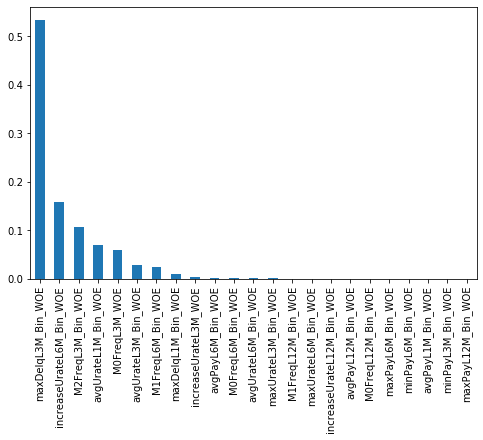

In [57]:
plt.figure(figsize = (8,5))
pd.Series(importace, index = multi_analysis).sort_values(ascending=False).plot.bar()

先假定模型可以容纳5个特征，再逐步增加特征个数，直到有特征的系数为正，或者p值超过0.1


In [58]:
n = 5
featureSelected = [i[0] for i in featureImportanceSorted[:n]]
X_train = X[featureSelected+['const']]
logit = sm.Logit(y, X_train)
logit_result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.261689
         Iterations 7


In [59]:
print(logit_result.summary())

                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                28099
Model:                          Logit   Df Residuals:                    28093
Method:                           MLE   Df Model:                            5
Date:                Mon, 30 Mar 2020   Pseudo R-squ.:                  0.3534
Time:                        16:55:26   Log-Likelihood:                -7353.2
converged:                       True   LL-Null:                       -11372.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
maxDelqL3M_Bin_WOE          -0.8272      0.018    -45.860      0.000      -0.863      -0.792
increaseUrateL6M_Bin_WOE    -1.2966      0.060    -21.528      0.000      -1.415      -1.

In [60]:
n = 5
while(n<len(featureImportanceSorted)):
    nextVar = featureImportanceSorted[n][0]
    featureSelected = featureSelected + [nextVar]
    X_train = X[featureSelected+['const']]
    logit = sm.Logit(y, X_train,)
    logit_result = logit.fit()
    params = logit_result.params
    print("current var is ",nextVar,'   ', params[nextVar])
    if max(params) < 0:
        n += 1
    else:
        featureSelected.remove(nextVar)
        n += 1

Optimization terminated successfully.
         Current function value: 0.260816
         Iterations 7
current var is  avgUrateL3M_Bin_WOE     -0.6344921536866451
Optimization terminated successfully.
         Current function value: 0.260514
         Iterations 7
current var is  M1FreqL6M_Bin_WOE     -0.12734209272525582
Optimization terminated successfully.
         Current function value: 0.260098
         Iterations 7
current var is  maxDelqL1M_Bin_WOE     -0.12931346268820676
Optimization terminated successfully.
         Current function value: 0.259965
         Iterations 7
current var is  increaseUrateL3M_WOE     -0.25930721620281016
Optimization terminated successfully.
         Current function value: 0.259452
         Iterations 7
current var is  avgPayL6M_Bin_WOE     -0.18973676141012363
Optimization terminated successfully.
         Current function value: 0.259076
         Iterations 7
current var is  M0FreqL6M_Bin_WOE     0.19737349227229262
Optimization terminated succes

可用L1约束，直到所有变量显著


In [61]:
X2 = X[featureSelected+['const']]
for alpha in range(100,0,-1):
    l1_logit = sm.Logit.fit_regularized(sm.Logit(y, X2), start_params=None, method='l1', alpha=alpha)
    pvalues = l1_logit.pvalues
    params = l1_logit.params
    if max(pvalues)>=0.1 or max(params)>0:
        break

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.280759550874888
            Iterations: 94
            Function evaluations: 94
            Gradient evaluations: 94


C:\Users\Junbo\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Junbo\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Junbo\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [62]:
bestAlpha = alpha + 1
l1_logit = sm.Logit.fit_regularized(sm.Logit(y, X2), start_params=None, method='l1', alpha=bestAlpha)
params = l1_logit.params
params2 = params.to_dict()
featuresInModel = [k for k, v in params2.items() if k!='const' and v < -0.0000001]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2809512631584162
            Iterations: 94
            Function evaluations: 95
            Gradient evaluations: 94


## 4.3 最终模型

In [63]:
X_train = X[featuresInModel + ['const']]
logit = sm.Logit(y, X_train)
logit_result = logit.fit()
trainData['pred'] = logit_result.predict(X_train)

Optimization terminated successfully.
         Current function value: 0.259463
         Iterations 7


In [64]:
print(logit_result.summary())

                           Logit Regression Results                           
Dep. Variable:                  label   No. Observations:                28099
Model:                          Logit   Df Residuals:                    28088
Method:                           MLE   Df Model:                           10
Date:                Mon, 30 Mar 2020   Pseudo R-squ.:                  0.3589
Time:                        16:55:27   Log-Likelihood:                -7290.6
converged:                       True   LL-Null:                       -11372.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
maxDelqL3M_Bin_WOE          -0.7623      0.026    -29.589      0.000      -0.813      -0.712
increaseUrateL6M_Bin_WOE    -1.2612      0.061    -20.621      0.000      -1.381      -1.

# 5. 测试集评价模型

In [65]:
# 准备WOE编码后的变量
modelFeatures = [i.replace('_Bin','').replace('_WOE','') for i in featuresInModel]
'''
['maxDelqL3M',
 'increaseUrateL6M',
 'M0FreqL3M',
 'avgUrateL1M',
 'M2FreqL3M',
 'M1FreqL6M',
 'avgUrateL3M',
 'maxDelqL1M',
 'avgPayL6M',
 'M1FreqL12M']
'''
numFeatures = [i for i in modelFeatures if i in numericalFeatures]
charFeatures = [i for i in modelFeatures if i in categoricalFeatures]

In [66]:
#满足变量的数据预处理
testData['maxDelqL1M'] = testData.apply(lambda x: DelqFeatures(x,1,'max delq'),axis=1)
testData['maxDelqL3M'] = testData.apply(lambda x: DelqFeatures(x,3,'max delq'),axis=1)
# testData['M2FreqL3M'] = testData.apply(lambda x: DelqFeatures(x, 3, 'M2 times'), axis=1)
testData['M0FreqL3M'] = testData.apply(lambda x: DelqFeatures(x,3,'M0 times'),axis=1)
testData['M1FreqL6M'] = testData.apply(lambda x: DelqFeatures(x, 6, 'M1 times'), axis=1)
testData['M2FreqL3M'] = testData.apply(lambda x: DelqFeatures(x, 3, 'M2 times'), axis=1)
testData['M1FreqL12M'] = testData.apply(lambda x: DelqFeatures(x, 12, 'M1 times'), axis=1)
# testData['maxUrateL6M'] = testData.apply(lambda x: UrateFeatures(x,6,'max utilization rate'),axis = 1)
testData['avgUrateL1M'] = testData.apply(lambda x: UrateFeatures(x,1, 'mean utilization rate'),axis=1)
testData['avgUrateL3M'] = testData.apply(lambda x: UrateFeatures(x,3, 'mean utilization rate'),axis=1)
# testData['avgUrateL6M'] = testData.apply(lambda x: UrateFeatures(x,6, 'mean utilization rate'),axis=1)
testData['increaseUrateL6M'] = testData.apply(lambda x: UrateFeatures(x, 6, 'increase utilization rate'),axis=1)
# testData['avgPayL3M'] = testData.apply(lambda x: PaymentFeatures(x, 3, 'mean payment ratio'),axis=1)
testData['avgPayL6M'] = testData.apply(lambda x: PaymentFeatures(x, 6, 'mean payment ratio'),axis=1)

In [67]:
#合并分箱
testData['M2FreqL3M_Bin'] = testData['M2FreqL3M'].apply(lambda x: int(x>=1))
testData['maxDelqL1M_Bin'] = testData['maxDelqL1M'].apply(lambda x: MergeByCondition(x,['==0','==1','>=2']))
testData['maxDelqL3M_Bin'] = testData['maxDelqL3M'].apply(lambda x: MergeByCondition(x,['==0','==1','>=2']))

In [68]:
for var in numFeatures:
    newBin = var+"_Bin"
    bin = [list(i.values()) for i in bin_dict if var in i][0][0]
    testData[newBin] = testData[var].apply(lambda x: AssignBin(x,bin))
 
finalFeatures = [i+'_Bin' for i in numFeatures] + ['M2FreqL3M_Bin','maxDelqL1M_Bin','maxDelqL3M_Bin','M0FreqL3M']

In [69]:
for var in finalFeatures:
    var2 = var+"_WOE"
    testData[var2] = testData[var].apply(lambda x: WOE_IV_dict[var]['WOE'][x])

In [70]:
X_test = testData[featuresInModel]
X_test = sm.add_constant(X_test)
testData['pred'] = logit_result.predict(X_test)

C:\Users\Junbo\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [71]:
fpr,tpr,_ = roc_curve(testData['label'],testData['pred'])
auc = roc_auc_score(testData['label'],testData['pred'])
ks = max(tpr-fpr)

In [72]:
print('KS = {:.2f}, AUC = {:.2f}'.format(ks,auc))

KS = 0.61, AUC = 0.83


KS＝0.61， AUC ＝ 0.83，都高于30%的标准。因此该模型是可用的。

# 6. 计算分数

In [73]:
def Prob2Score(prob, basePoint, PDO):
    #将概率转化成分数且为正整数
    y = np.log(prob/(1-prob))
    return int(basePoint+PDO/np.log(2)*(-y))

(array([  17.,   20.,    7.,   12.,   16.,   11.,    5.,    3.,    0.,
           3.,   14.,   13.,   12.,   15.,   20.,   12.,   11.,    6.,
          13.,    5.,    3.,    3.,    8.,   12.,   16.,   30.,   15.,
          22.,   31.,   25.,   15.,   33.,   31.,   38.,   43.,   43.,
          57.,   52.,   63.,   77.,   80.,   63.,   44.,   55.,  124.,
         145.,   58.,  169.,  226.,   72.,   95.,  149.,  115.,   73.,
           6.,   24.,   60.,   54.,   24.,   18.,   28.,   41.,   50.,
          75.,   61.,   50.,   61.,   64.,   60.,   94.,  201.,  171.,
          72.,   96.,  379.,  562.,  448.,  378.,  476.,  458.,  330.,
         269.,  113.,   31.,   10.,   12.,   33.,  234.,  252.,    8.,
          94.,  520., 1032.,  315.,  608.,  224.,  782.,  196.,  551.,
         118.]),
 array([-251.  , -238.97, -226.94, -214.91, -202.88, -190.85, -178.82,
        -166.79, -154.76, -142.73, -130.7 , -118.67, -106.64,  -94.61,
         -82.58,  -70.55,  -58.52,  -46.49,  -34.46,  -22.43

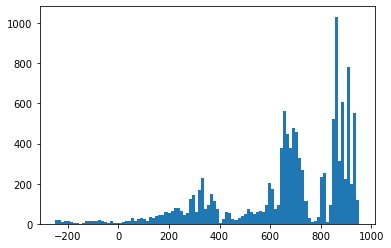

In [74]:
BasePoint, PDO = 500,50
testData['score'] = testData['pred'].apply(lambda x: Prob2Score(x, BasePoint, PDO))
plt.hist(testData['score'],bins=100)